# Compare cell lines 

__Aim:__ Consistency analysis across cell lines using pathway enrichment results to find commonly up/down regulated pathways and their genes. 

___
- https://github.com/tanghaibao/goatools
- https://gseapy.readthedocs.io/en/latest/index.html

In [1]:
import sys
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from time import time 
from glob import glob
from matplotlib.pyplot import subplots
from itertools import chain
from functools import reduce
from venn import venn

# sys.path.append('/rumi/shams/abe/Projects/ipage-down/')
sys.path.append('/data_gilbert/home/aarab/Projects/ipage-down/')

import ipage_down as ipd

## Run iPAGE

Hani: _"You must redo iPAGE with `--independence=0` option for comparing results between multiple smaples."_

In [1]:
cat ../ipage_loop.sh

## $1: input file contain table with first two columns as gene name/id and numeric value
pattern='msigdb*'
# pattern='human_*_gs*'

expfile=`basename $1`
outdir=${1/.txt/};

mkdir -p $outdir
cd $outdir; cd ../

for f in `ls -d $PAGEDIR/PAGE_DATA/ANNOTATIONS/${pattern}`; do

    base=`basename "$f"`;
    echo '________________' $base '________________';

    if [ -d "${outdir}/${base}/" ]; 
    then
        echo 'This result exist!';
    else
        # Run iPAGE 
        perl $PAGEDIR/page.pl --expfile=$expfile --species=$base --exptype=continuous --ebins=11 --nodups=1 --independence=0; 
        # --independence=0; option for comparing results between multiple smaples.
        wait

        mv -v ${expfile}_PAGE/ ${outdir}/${base}/;

        # remove the result folder if it was empty
        counter="$(wc -l < ${outdir}/${base}/pvmatrix.txt)"
        if [ $counter -le "$(echo '1')" ] || [ -z $counter ]
        then
            rm -r ${outdir}/${base}/
        else
            # keep com

In [ ]:
# %%bash
# echo '<h1>'Enrichment analysis'<h1>' >> README.md

# declare -a Comp=('6h' '72h' '120h')

# for f in `ls -d /flash/bin/iPAGEv1.0/PAGE_DATA/ANNOTATIONS/human_ensembl*`; do
#     base=`basename "$f"`
#     echo '<table>' >> README.md
#     echo '  <tr>' >> README.md
#     echo '  <h2>'$base'<h2>' >> README.md
#     for C in "${Comp[@]}"; do
#         echo '    <td><img src='${C}'_delta_exp/'${base}'.all.png style="width:600px">' >> README.md
#     done
#     echo '  <tr>' >> README.md
#     echo '<table>' >> README.md
# done

## $\Delta$Expression

#### `ind0`

In [ ]:
%%bash
export PAGEDIR='/data_gilbert/home/aarab/iPAGE'

cd exp/
ls *_delta_exp.txt | parallel -j18 -k bash ../../ipage_loop.sh
cd ../

In [20]:
!rm -r exp/*delta_exp/*/*.html exp/*delta_exp/*/*.eps exp/*delta_exp/*/imgsrc exp/*delta_exp/*/SUMMARY

In [29]:
%%bash 
for f in  exp/*delta_exp/; do o=${f/delta_exp/delta_exp_ind0}; mv -v $f $o; done 

‘exp/hl60_120h_delta_exp/’ -> ‘exp/hl60_120h_delta_exp_ind0/’
‘exp/hl60_6h_delta_exp/’ -> ‘exp/hl60_6h_delta_exp_ind0/’
‘exp/hl60_72h_delta_exp/’ -> ‘exp/hl60_72h_delta_exp_ind0/’
‘exp/hl60_72h_only_delta_exp/’ -> ‘exp/hl60_72h_only_delta_exp_ind0/’
‘exp/kg1_delta_exp/’ -> ‘exp/kg1_delta_exp_ind0/’
‘exp/molm14_delta_exp/’ -> ‘exp/molm14_delta_exp_ind0/’
‘exp/ociaml2_delta_exp/’ -> ‘exp/ociaml2_delta_exp_ind0/’
‘exp/ociaml3_delta_exp/’ -> ‘exp/ociaml3_delta_exp_ind0/’
‘exp/thp1_delta_exp/’ -> ‘exp/thp1_delta_exp_ind0/’


#### `ind1`

In [ ]:
%%bash
export PAGEDIR='/data_gilbert/home/aarab/iPAGE'

cd exp/
ls *_delta_exp.txt | parallel -j18 -k bash ../../ipage_loop.sh
cd ../

In [77]:
%%bash 
for f in  exp/*_delta_exp/; do o=${f/_delta_exp/_delta_exp_ind1}; mv -v $f $o; done 

‘exp/hl60_120h_delta_exp/’ -> ‘exp/hl60_120h_delta_exp_ind1/’
‘exp/hl60_6h_delta_exp/’ -> ‘exp/hl60_6h_delta_exp_ind1/’
‘exp/hl60_72h_delta_exp/’ -> ‘exp/hl60_72h_delta_exp_ind1/’
‘exp/hl60_72h_only_delta_exp/’ -> ‘exp/hl60_72h_only_delta_exp_ind1/’
‘exp/kg1_delta_exp/’ -> ‘exp/kg1_delta_exp_ind1/’
‘exp/molm14_delta_exp/’ -> ‘exp/molm14_delta_exp_ind1/’
‘exp/ociaml2_delta_exp/’ -> ‘exp/ociaml2_delta_exp_ind1/’
‘exp/ociaml3_delta_exp/’ -> ‘exp/ociaml3_delta_exp_ind1/’
‘exp/thp1_delta_exp/’ -> ‘exp/thp1_delta_exp_ind1/’


### Remake from pvmatrix (correct bin clusters)

In [2]:
ls -d exp/*_ind1

exp/hl60_120h_delta_exp_ind1/      exp/molm14_delta_exp_ind1/
exp/hl60_6h_delta_exp_ind1/        exp/ociaml2_delta_exp_ind1/
exp/hl60_72h_delta_exp_ind1/       exp/ociaml3_delta_exp_ind1/
exp/hl60_72h_only_delta_exp_ind1/  exp/thp1_delta_exp_ind1/
exp/kg1_delta_exp_ind1/


#### hl60_6h_delta_exp_ind1

In [14]:
ind1 = 'exp/hl60_6h_delta_exp_ind1'
ipd.clean_bins_range(
    pd.concat([
        ipd.read_pvmatrix(f'{ind1}/msigdb_v7.4_c5.all/pvmatrix.L.txt'),
        ipd.read_pvmatrix(f'{ind1}/msigdb_v7.4_c5.all/pvmatrix.R.txt')
    ])
).drop_duplicates().to_csv(f"{ind1.replace('_ind1','_pvmatrix')}.txt",sep = '\t')

#### hl60_72h_delta_exp_ind1

In [15]:
ind1 = 'exp/hl60_72h_delta_exp_ind1'
ipd.clean_bins_range(
    pd.concat([
        ipd.read_pvmatrix(f'{ind1}/msigdb_v7.4_c5.all/pvmatrix.L.txt'),
        ipd.read_pvmatrix(f'{ind1}/msigdb_v7.4_c5.all/pvmatrix.R.txt')
    ])
).drop_duplicates().to_csv(f"{ind1.replace('_ind1','_pvmatrix')}.txt",sep = '\t')

#### hl60_120h_delta_exp_ind1   

In [16]:
ind1 = 'exp/hl60_120h_delta_exp_ind1'
ipd.clean_bins_range(
    pd.concat([
        ipd.read_pvmatrix(f'{ind1}/msigdb_v7.4_c5.all/pvmatrix.L.txt'),
        ipd.read_pvmatrix(f'{ind1}/msigdb_v7.4_c5.all/pvmatrix.R.txt')
    ])
).drop_duplicates().to_csv(f"{ind1.replace('_ind1','_pvmatrix')}.txt",sep = '\t')

#### hl60_72h_only_delta_exp_ind1

In [17]:
ind1 = 'exp/hl60_72h_only_delta_exp_ind1'
ipd.clean_bins_range(
    pd.concat([
        ipd.read_pvmatrix(f'{ind1}/msigdb_v7.4_c5.all/pvmatrix.L.txt'),
        ipd.read_pvmatrix(f'{ind1}/msigdb_v7.4_c5.all/pvmatrix.R.txt')
    ])
).drop_duplicates().to_csv(f"{ind1.replace('_ind1','_pvmatrix')}.txt",sep = '\t')

#### molm14_delta_exp_ind1

In [18]:
ind1 = 'exp/molm14_delta_exp_ind1'
ipd.clean_bins_range(
    pd.concat([
        ipd.read_pvmatrix(f'{ind1}/msigdb_v7.4_c5.all/pvmatrix.L.txt'),
        ipd.read_pvmatrix(f'{ind1}/msigdb_v7.4_c5.all/pvmatrix.R.txt')
    ])
).drop_duplicates().to_csv(f"{ind1.replace('_ind1','_pvmatrix')}.txt",sep = '\t')

#### ociaml2_delta_exp_ind1

In [19]:
ind1 = 'exp/ociaml2_delta_exp_ind1'
ipd.clean_bins_range(
    pd.concat([
        ipd.read_pvmatrix(f'{ind1}/msigdb_v7.4_c5.all/pvmatrix.L.txt'),
        ipd.read_pvmatrix(f'{ind1}/msigdb_v7.4_c5.all/pvmatrix.R.txt')
    ])
).drop_duplicates().to_csv(f"{ind1.replace('_ind1','_pvmatrix')}.txt",sep = '\t')

#### ociaml3_delta_exp_ind1

In [20]:
ind1 = 'exp/ociaml3_delta_exp_ind1'
ipd.clean_bins_range(
    pd.concat([
        ipd.read_pvmatrix(f'{ind1}/msigdb_v7.4_c5.all/pvmatrix.L.txt'),
        ipd.read_pvmatrix(f'{ind1}/msigdb_v7.4_c5.all/pvmatrix.R.txt')
    ])
).drop_duplicates().to_csv(f"{ind1.replace('_ind1','_pvmatrix')}.txt",sep = '\t')

#### thp1_delta_exp_ind1

In [21]:
ind1 = 'exp/thp1_delta_exp_ind1'
ipd.clean_bins_range(
    pd.concat([
        ipd.read_pvmatrix(f'{ind1}/msigdb_v7.4_c5.all/pvmatrix.L.txt'),
        ipd.read_pvmatrix(f'{ind1}/msigdb_v7.4_c5.all/pvmatrix.R.txt')
    ])
).drop_duplicates().to_csv(f"{ind1.replace('_ind1','_pvmatrix')}.txt",sep = '\t')

#### kg1_delta_exp_ind1

In [22]:
ind1 = 'exp/kg1_delta_exp_ind1'
ipd.clean_bins_range(
    pd.concat([
        ipd.read_pvmatrix(f'{ind1}/msigdb_v7.4_c5.all/pvmatrix.L.txt'),
        ipd.read_pvmatrix(f'{ind1}/msigdb_v7.4_c5.all/pvmatrix.R.txt')
    ])
).drop_duplicates().to_csv(f"{ind1.replace('_ind1','_pvmatrix')}.txt",sep = '\t')

___

In [32]:
%%bash 
cd exp
for exp in *delta_exp.txt; do 
    pv=${exp/.txt/_pvmatrix.txt};
    bash ../../ipage_draw_matrix.sh $exp $pv;
done
cd ../

Reading matrix ... Done.
Cluster rows .. best merge is 11, 12, 0.0352146253990937
best merge is 13, 19, 0.0458137702468012
best merge is 5, 7, 0.0558637106600443
best merge is 0, 3, 0.0598616994999702
best merge is 11, 24, 0.0756444324195134
best merge is 14, 15, 0.0788211073661067
best merge is 0, 6, 0.0803175253761167
best merge is 11, 17, 0.08118191202991
best merge is 1, 5, 0.0837272666153618
best merge is 13, 20, 0.110381874673303
best merge is 1, 4, 0.113902662707769
best merge is 14, 16, 0.11652188453818
best merge is 11, 25, 0.12041623580258
best merge is 18, 21, 0.157927385643219
best merge is 13, 14, 0.167740169991511
best merge is 0, 2, 0.198855049062808
best merge is 11, 23, 0.204377890752968
best merge is 11, 13, 0.247425358426626
best merge is 0, 1, 0.276461783106941
best merge is 11, 22, 0.377966993446105
best merge is 11, 18, 0.396517540331822
best merge is 0, 8, 0.477026031668401
order classes
8 - 0.589618723196522
15 - 0.430359824008514
11 12 24 17 25 23 13 19 20 14 1

## $\Delta$Stability

#### `ind0`

In [ ]:
%%bash
export PAGEDIR='/data_gilbert/home/aarab/iPAGE'

cd stbl/
ls *_delta_stbl.txt | parallel -j18 -k bash ../../ipage_loop.sh
cd ../

In [21]:
!rm -r stbl/*delta_stbl/*/*.html stbl/*delta_stbl/*/*.eps stbl/*delta_stbl/*/imgsrc stbl/*delta_stbl/*/SUMMARY

In [30]:
%%bash 
for f in  stbl/*delta_stbl/; do o=${f/delta_stbl/delta_stbl_ind0}; mv -v $f $o; done 

‘stbl/hl60_120h_delta_stbl/’ -> ‘stbl/hl60_120h_delta_stbl_ind0/’
‘stbl/hl60_6h_delta_stbl/’ -> ‘stbl/hl60_6h_delta_stbl_ind0/’
‘stbl/hl60_72h_delta_stbl/’ -> ‘stbl/hl60_72h_delta_stbl_ind0/’
‘stbl/kg1_delta_stbl/’ -> ‘stbl/kg1_delta_stbl_ind0/’
‘stbl/molm14_delta_stbl/’ -> ‘stbl/molm14_delta_stbl_ind0/’
‘stbl/ociaml2_delta_stbl/’ -> ‘stbl/ociaml2_delta_stbl_ind0/’
‘stbl/ociaml3_delta_stbl/’ -> ‘stbl/ociaml3_delta_stbl_ind0/’
‘stbl/thp1_delta_stbl/’ -> ‘stbl/thp1_delta_stbl_ind0/’


#### `ind1`

In [ ]:
%%bash
export PAGEDIR='/data_gilbert/home/aarab/iPAGE'

cd stbl/
ls *_delta_stbl.txt | parallel -j18 -k bash ../../ipage_loop.sh
cd ../

In [31]:
!rm -r stbl/*delta_stbl/*/*.html stbl/*delta_stbl/*/*.eps stbl/*delta_stbl/*/imgsrc stbl/*delta_stbl/*/SUMMARY

In [32]:
%%bash 
for f in  stbl/*delta_stbl/; do o=${f/delta_stbl/delta_stbl_ind1}; mv -v $f $o; done 

‘stbl/hl60_120h_delta_stbl/’ -> ‘stbl/hl60_120h_delta_stbl_ind1/’
‘stbl/hl60_6h_delta_stbl/’ -> ‘stbl/hl60_6h_delta_stbl_ind1/’
‘stbl/hl60_72h_delta_stbl/’ -> ‘stbl/hl60_72h_delta_stbl_ind1/’
‘stbl/kg1_delta_stbl/’ -> ‘stbl/kg1_delta_stbl_ind1/’
‘stbl/molm14_delta_stbl/’ -> ‘stbl/molm14_delta_stbl_ind1/’
‘stbl/ociaml2_delta_stbl/’ -> ‘stbl/ociaml2_delta_stbl_ind1/’
‘stbl/ociaml3_delta_stbl/’ -> ‘stbl/ociaml3_delta_stbl_ind1/’
‘stbl/thp1_delta_stbl/’ -> ‘stbl/thp1_delta_stbl_ind1/’


### Remake from pvmatrix (correct bin clusters)

In [49]:
ls -d stbl/*_ind1

stbl/hl60_120h_delta_stbl_ind1/  stbl/molm14_delta_stbl_ind1/
stbl/hl60_6h_delta_stbl_ind1/    stbl/ociaml2_delta_stbl_ind1/
stbl/hl60_72h_delta_stbl_ind1/   stbl/ociaml3_delta_stbl_ind1/
stbl/kg1_delta_stbl_ind1/        stbl/thp1_delta_stbl_ind1/


#### hl60_6h_delta_stbl_ind1

In [23]:
ind1 = 'hl60_6h_delta_stbl_ind1'
ipd.clean_bins_range(
    pd.concat([
        ipd.read_pvmatrix(f'stbl/{ind1}/msigdb_v7.4_c5.all/pvmatrix.L.txt'),
        ipd.read_pvmatrix(f'stbl/{ind1}/msigdb_v7.4_c5.all/pvmatrix.R.txt')
    ])
).drop_duplicates().to_csv(f"stbl/{ind1.replace('_ind1','_pvmatrix')}.txt",sep = '\t')

#### hl60_72h_delta_stbl_ind1

In [24]:
ind1 = 'hl60_72h_delta_stbl_ind1'
ipd.clean_bins_range(
    pd.concat([
        ipd.read_pvmatrix(f'stbl/{ind1}/msigdb_v7.4_c5.all/pvmatrix.L.txt'),
        ipd.read_pvmatrix(f'stbl/{ind1}/msigdb_v7.4_c5.all/pvmatrix.R.txt')
    ])
).drop_duplicates().to_csv(f"stbl/{ind1.replace('_ind1','_pvmatrix')}.txt",sep = '\t')

#### hl60_120h_delta_stbl_ind1

In [25]:
ind1 = 'hl60_120h_delta_stbl_ind1'
ipd.clean_bins_range(
    pd.concat([
        ipd.read_pvmatrix(f'stbl/{ind1}/msigdb_v7.4_c5.all/pvmatrix.L.txt'),
        ipd.read_pvmatrix(f'stbl/{ind1}/msigdb_v7.4_c5.all/pvmatrix.R.txt')
    ])
).drop_duplicates().to_csv(f"stbl/{ind1.replace('_ind1','_pvmatrix')}.txt",sep = '\t')

#### molm14_delta_stbl_ind1

In [26]:
ind1 = 'molm14_delta_stbl_ind1'
ipd.clean_bins_range(
    pd.concat([
        ipd.read_pvmatrix(f'stbl/{ind1}/msigdb_v7.4_c5.all/pvmatrix.L.txt'),
        ipd.read_pvmatrix(f'stbl/{ind1}/msigdb_v7.4_c5.all/pvmatrix.R.txt')
    ])
).drop_duplicates().to_csv(f"stbl/{ind1.replace('_ind1','_pvmatrix')}.txt",sep = '\t')

#### ociaml2_delta_stbl_ind1

In [27]:
ind1 = 'ociaml2_delta_stbl_ind1'
ipd.clean_bins_range(
    pd.concat([
        ipd.read_pvmatrix(f'stbl/{ind1}/msigdb_v7.4_c5.all/pvmatrix.L.txt'),
        ipd.read_pvmatrix(f'stbl/{ind1}/msigdb_v7.4_c5.all/pvmatrix.R.txt')
    ])
).drop_duplicates().to_csv(f"stbl/{ind1.replace('_ind1','_pvmatrix')}.txt",sep = '\t')

#### ociaml3_delta_stbl_ind1

In [28]:
ind1 = 'ociaml3_delta_stbl_ind1'
ipd.clean_bins_range(
    pd.concat([
        ipd.read_pvmatrix(f'stbl/{ind1}/msigdb_v7.4_c5.all/pvmatrix.L.txt'),
        ipd.read_pvmatrix(f'stbl/{ind1}/msigdb_v7.4_c5.all/pvmatrix.R.txt')
    ])
).drop_duplicates().to_csv(f"stbl/{ind1.replace('_ind1','_pvmatrix')}.txt",sep = '\t')

#### kg1_delta_stbl_ind1

In [29]:
ind1 = 'kg1_delta_stbl_ind1'
ipd.clean_bins_range(
    pd.concat([
        ipd.read_pvmatrix(f'stbl/{ind1}/msigdb_v7.4_c5.all/pvmatrix.L.txt'),
        ipd.read_pvmatrix(f'stbl/{ind1}/msigdb_v7.4_c5.all/pvmatrix.R.txt')
    ])
).drop_duplicates().to_csv(f"stbl/{ind1.replace('_ind1','_pvmatrix')}.txt",sep = '\t')

#### thp1_delta_stbl_ind1

In [30]:
ind1 = 'thp1_delta_stbl_ind1'
ipd.clean_bins_range(
    pd.concat([
        ipd.read_pvmatrix(f'stbl/{ind1}/msigdb_v7.4_c5.all/pvmatrix.L.txt'),
        ipd.read_pvmatrix(f'stbl/{ind1}/msigdb_v7.4_c5.all/pvmatrix.R.txt')
    ])
).drop_duplicates().to_csv(f"stbl/{ind1.replace('_ind1','_pvmatrix')}.txt",sep = '\t')

___

In [31]:
%%bash 
cd stbl
for exp in *delta_stbl.txt; do 
    pv=${exp/.txt/_pvmatrix.txt};
    bash ../../ipage_draw_matrix.sh $exp $pv;
done
cd ../

Reading matrix ... Done.
Cluster rows .. best merge is 1, 3, 0.413997434319903
order classes
0
1
2
3
Done.Start drawing
0.4	-0.44
GOBP_RESPONSE_TO_STEROL, 
GOBP_RECEPTOR_SIGNALING_PATHWAY_VIA_STAT, 
GOBP_REGULATION_OF_MITOCHONDRION_ORGANIZATION, 
GOBP_POSITIVE_REGULATION_OF_WNT_SIGNALING_PATHWAY, 
Outputing EPS file hl60_120h_delta_stbl.txt_PAGE/hl60_120h_delta_stbl.txt.summary.eps
Convert to PDF hl60_120h_delta_stbl.txt_PAGE/hl60_120h_delta_stbl.txt.summary.pdf
Finished.
‘hl60_120h_delta_stbl.txt_PAGE/hl60_120h_delta_stbl.txt.summary.pdf’ -> ‘hl60_120h_delta_stbl.pdf’
removed ‘hl60_120h_delta_stbl.txt_PAGE/hl60_120h_delta_stbl.txt.summary.eps’
removed directory: ‘hl60_120h_delta_stbl.txt_PAGE’
Reading matrix ... Done.
Start drawing
0.22	-0.22
GOBP_STEROL_BIOSYNTHETIC_PROCESS, 
HP_HIGHLY_ARCHED_EYEBROW, 
Outputing EPS file hl60_6h_delta_stbl.txt_PAGE/hl60_6h_delta_stbl.txt.summary.eps
Convert to PDF hl60_6h_delta_stbl.txt_PAGE/hl60_6h_delta_stbl.txt.summary.pdf
Finished.
‘hl60_6h_delta

## Load iPAGE results - iPAGE-down

In [419]:
data = dict(
    [(exp.split('/')[1].replace('_delta_exp',''),ipd.make_ipage_run_data_frame(exp)) for exp in glob('exp/*delta_exp/')]
)

del data['hl60_120h']
del data['hl60_72h']
del data['hl60_6h']

Exp_up = dict([(
    line,
    # to make it unique pathway accross different msigdb clusters
    # list(dict(
        data[line][data[line].iloc[:,1] > 2].sort_index(level='gs_cluster').index.tolist()
# )
    # .items()
    # )
) for line in data])

Exp_dn = dict([(
    line,
    # to make it unique pathway accross different msigdb clusters
    # list(dict(data[line].index[data[line].iloc[:,0] > 2].tolist()).items())
    data[line][data[line].iloc[:,0] > 2].sort_index(level='gs_cluster').index.tolist()
    
) for line in data])

In [420]:
# fig, ((ax1,ax2,ax3,ax4)) = subplots(ncols=2, nrows=1, figsize=(20, 10),dpi=300)

# for std,ax in zip(['Exp_dn', 'Exp_up', 'Stbl_dn', 'Stbl_up'],[ax1,ax2,ax3,ax4]):
#     venn(eval(std),fontsize=6,
# #          legend_loc=None,  
#          legend_loc="lower left",  
#          ax=ax)
#     ax.set_title(std,fontsize=15)

# fig.savefig('cell-line-consistency-Venn.pdf')
# plt.show()

### $\Delta$Expression

#### UpSetPlot

https://upsetplot.readthedocs.io/en/stable/


In [421]:
import upsetplot as us

from matplotlib.backends.backend_pdf import PdfPages

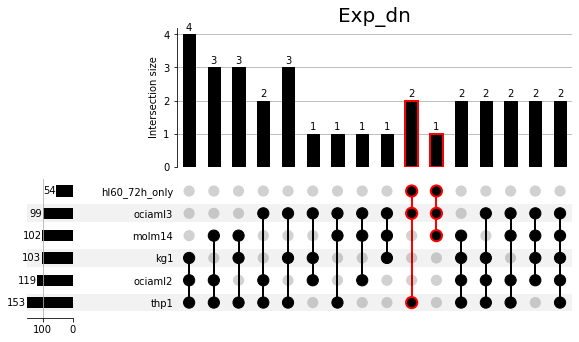

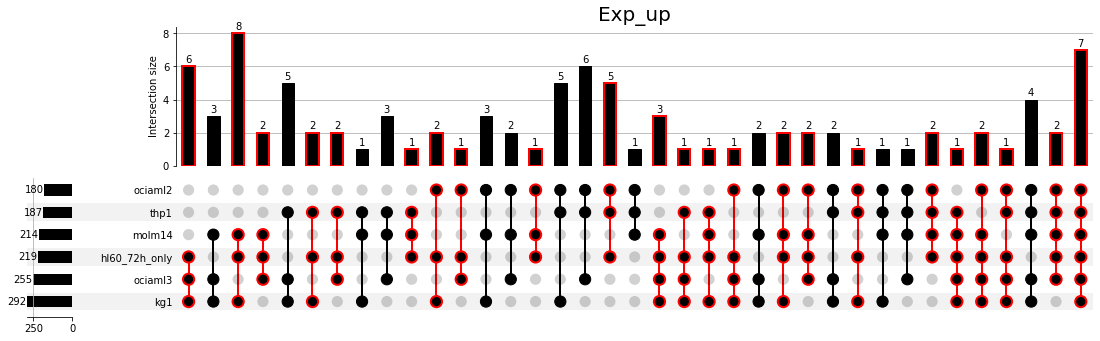

In [422]:
fig1 = plt.figure()
upset1 = us.UpSet(
    us.from_contents(Exp_dn),
    min_degree=3,        
    orientation='horizontal',show_counts=True
)
upset1.style_subsets(present='hl60_72h_only',edgecolor="red",linewidth=2)
upset1.plot(fig=fig1)
plt.title('Exp_dn',fontsize=20)
pdf.savefig()

fig2 = plt.figure()
upset2 = us.UpSet(
    us.from_contents(Exp_up),
    min_degree=3,        
    orientation='horizontal',show_counts=True)
upset2.style_subsets(present='hl60_72h_only',edgecolor="red",linewidth=2)
upset2.plot(fig=fig2)
plt.title('Exp_up',fontsize=20)
pdf.savefig()


In [468]:
# cat exp/hl60_120h_delta_exp/msigdb_v7.4_c5.all/pvmatrix.txt.killed

In [423]:
pws = set.intersection(*[{'::'.join(pw) for pw in Exp_up[val]} for val in Exp_up])
pws 

{'GOBP_HOMOPHILIC_CELL_ADHESION_VIA_PLASMA_MEMBRANE_ADHESION_MOLECULES::msigdb_v7.4_c5.all',
 'GOBP_HOMOPHILIC_CELL_ADHESION_VIA_PLASMA_MEMBRANE_ADHESION_MOLECULES::msigdb_v7.4_c5.go',
 'GOMF_EXTRACELLULAR_MATRIX_STRUCTURAL_CONSTITUENT::msigdb_v7.4_c5.go',
 'GSE41176_UNSTIM_VS_ANTI_IGM_STIM_TAK1_KO_BCELL_3H_DN::msigdb_v7.4_c7.all',
 'GSE41176_UNSTIM_VS_ANTI_IGM_STIM_TAK1_KO_BCELL_3H_DN::msigdb_v7.4_c7.immunesigdb',
 'MODULE_92::msigdb_v7.4_c4.all',
 'MODULE_92::msigdb_v7.4_c4.cm'}

In [424]:
def read_ipage_intersections_file(gs_cluster_path,gs=None):
    with open(f'{gs_cluster_path}/output.ipage_intersections') as raw:
        lines = [line for line in raw.read().splitlines()]
        if gs: 
            lines = [line.split('\t') for line in lines if re.search(gs, line)][1:]
        else:
            lines = [line.split('\t') for line in lines][1:]

        left  = dict([(line[0].split(' ')[0],line[2:]) for line in lines if line[1] == '0' ])
        right = dict([(line[0].split(' ')[0],line[2:]) for line in lines if line[1] == '10'])

    return left,right

#### See genes within the commonly enriched pathway 

In [450]:
def make_empty_genes_dict(pws,data):
    genes = dict.fromkeys(pws)
    for k in genes:
        genes[k]=dict.fromkeys(data)
        for j in genes[k]: genes[k][j]= {}
    return genes

In [453]:
left_genes = make_empty_genes_dict(pws,data)
right_genes= make_empty_genes_dict(pws,data)

for pw in pws:
    gs, gs_cluster = pw.split('::')
    print (30*'==')
    print(gs, gs_cluster)
    for exp in data:
        print (exp)
        l,r = read_ipage_intersections_file(
            f'exp/{exp}_delta_exp/{gs_cluster}', gs
        )
        
        if len(l) > 0:
            print(f'left: {l[gs]}')
            left_genes[pw][exp] = l[gs]

        if len(r) > 0:
            print(f'right: {r[gs]}')
            right_genes[pw][exp] = r[gs]

        print (30*'--')    

GOMF_EXTRACELLULAR_MATRIX_STRUCTURAL_CONSTITUENT msigdb_v7.4_c5.go
hl60_72h_only
right: ['COL9A2', 'LAMA3', 'LAMC2', 'COL11A1', 'COL19A1', 'COL16A1', 'CHADL', 'LAMA1', 'AEBP1', 'ASPN', 'IMPG1', 'SPARC', 'NID1', 'TGFBI', 'PXDN', 'MATN2', 'COL4A2', 'LAMC1', 'THBS1', 'EMILIN1', 'OIT3', 'LUM', 'HMCN1', 'MUC4', 'HMCN2', 'PRG3', 'MFAP4', 'ZPLD1', 'COL8A2', 'EFEMP2', 'COL6A5', 'MMRN2', 'THBS2', 'PRG2', 'COL14A1', 'COL27A1', 'MFAP5', 'MUC5AC']
------------------------------------------------------------
kg1
right: ['ANOS1', 'LTBP1', 'COL17A1', 'CHADL', 'SRPX', 'TFPI2', 'COL12A1', 'COL7A1', 'TGFBI', 'COL21A1', 'EMILIN2', 'ENAM', 'MATN2', 'COL4A2', 'THBS1', 'COL2A1', 'LUM', 'COL6A1', 'COL6A2', 'HMCN1', 'MUC4', 'HAPLN1', 'FBLN2', 'CTHRC1', 'COL3A1', 'LAMB2', 'EFEMP2', 'MMRN2', 'AMBN', 'BGN', 'COL18A1', 'EMILIN3', 'MUC6', 'THBS2', 'PRG2', 'COL14A1', 'COL25A1', 'LAMA2', 'COL27A1', 'COL13A1', 'MFAP5']
------------------------------------------------------------
molm14
right: ['DCN', 'ELN', 'COL11A1'

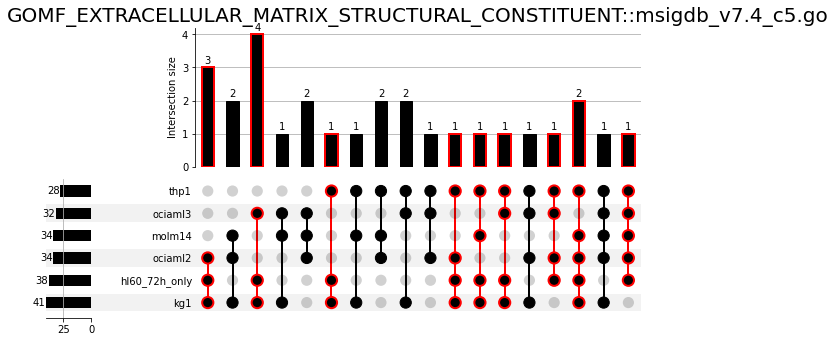

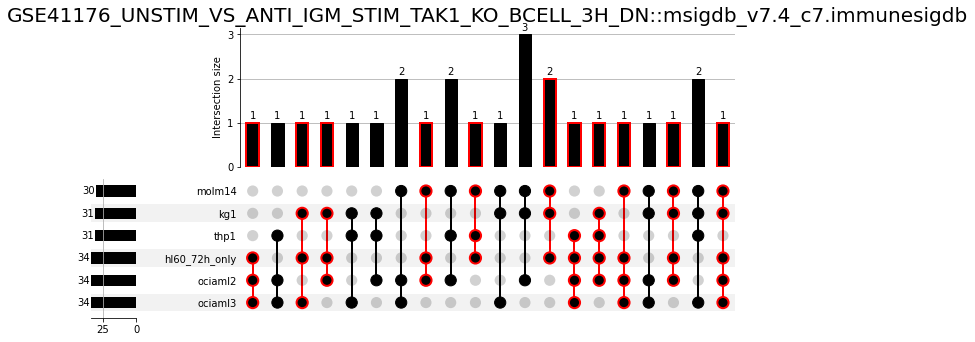

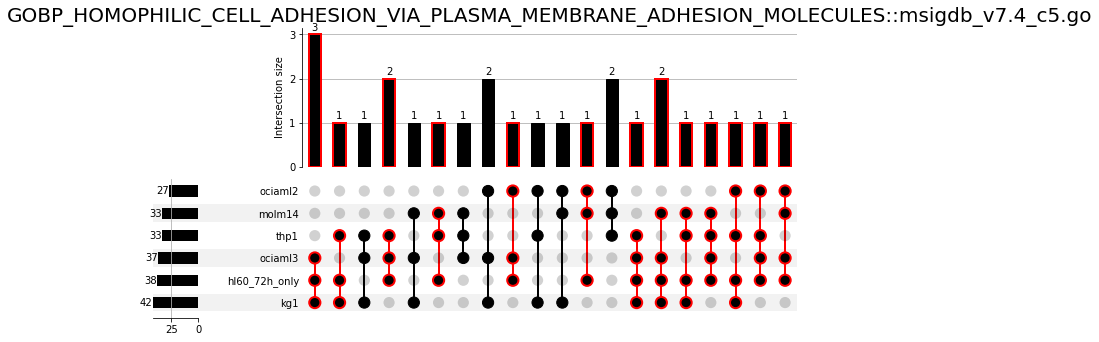

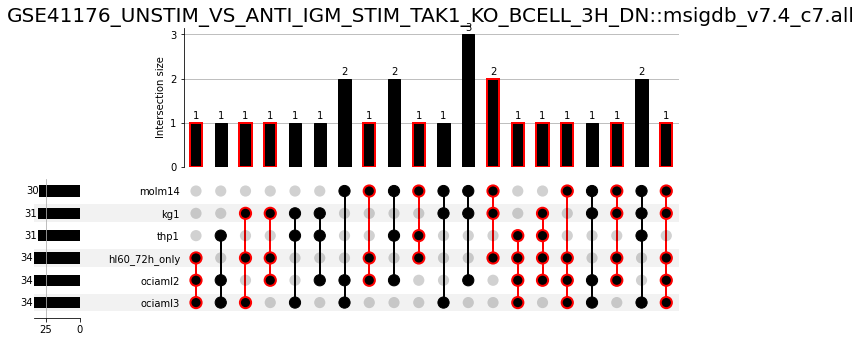

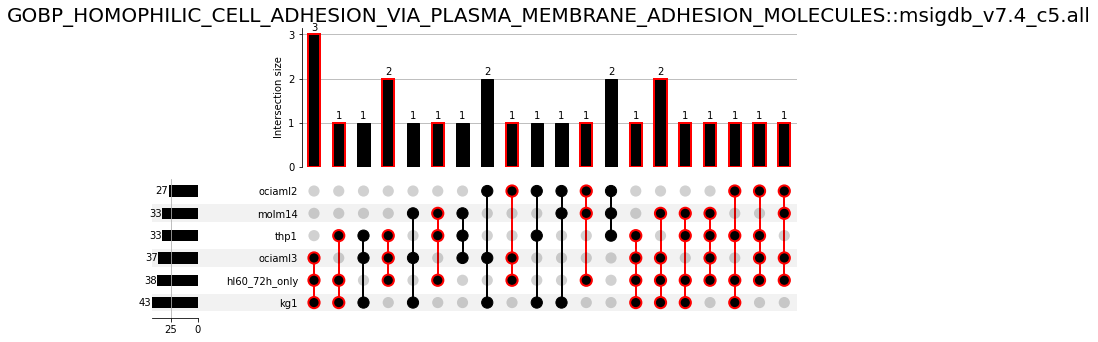

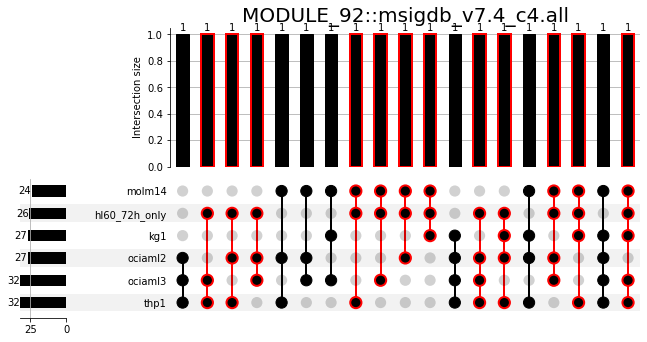

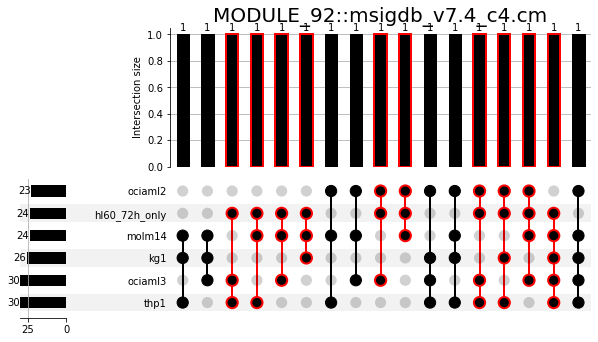

In [459]:
for pw in right_genes:
    fig = plt.figure()
    upset = us.UpSet(
        us.from_contents(right_genes[pw]),
        min_degree=3,
        orientation='horizontal',show_counts=True
    )
    upset.style_subsets(present='hl60_72h_only',edgecolor="red",linewidth=2)
    upset.plot(fig=fig)
    plt.title(pw,fontsize=20)
    plt.show()
    # pdf.savefig()

### $\Delta$Stability

#### UpSetPlot

https://upsetplot.readthedocs.io/en/stable/


In [421]:
import upsetplot as us

from matplotlib.backends.backend_pdf import PdfPages

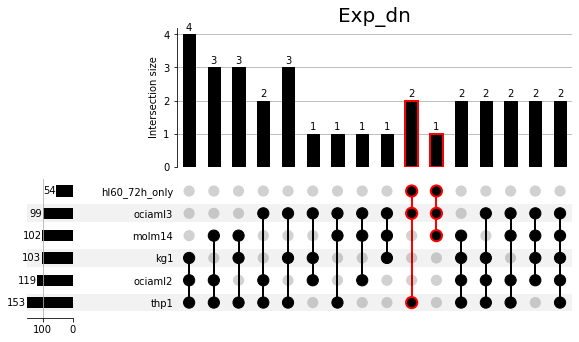

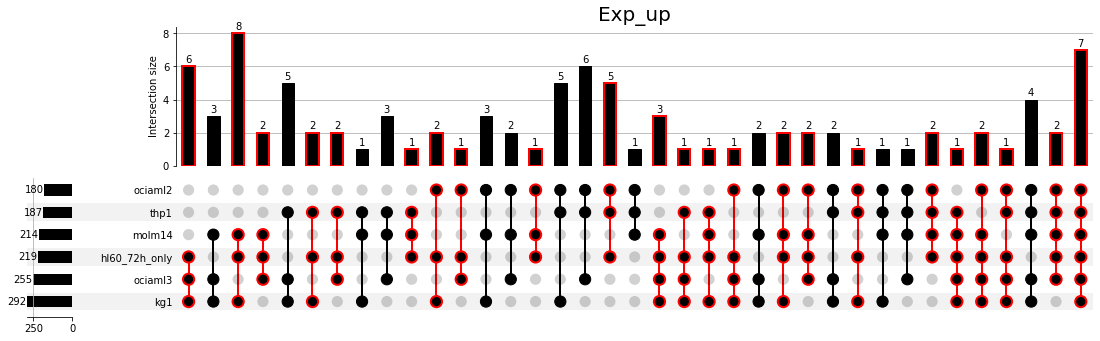

In [422]:
# with PdfPages('cell-line-consistency-UpSet.pdf') as pdf:
fig3 = plt.figure()
upset3 = us.UpSet(us.from_contents(Stbl_dn),orientation='horizontal',show_counts=True)
upset3.plot(fig=fig3)
plt.title('Stbl_dn',fontsize=20)
pdf.savefig()

fig4 = plt.figure()
upset = us.UpSet(us.from_contents(Stbl_up),orientation='horizontal',show_counts=True)
upset.plot()
plt.title('Stbl_up',fontsize=15)
pdf.savefig()

In [468]:
# cat exp/hl60_120h_delta_exp/msigdb_v7.4_c5.all/pvmatrix.txt.killed

In [423]:
pws = set.intersection(*[{'::'.join(pw) for pw in Exp_up[val]} for val in Exp_up])
pws 

{'GOBP_HOMOPHILIC_CELL_ADHESION_VIA_PLASMA_MEMBRANE_ADHESION_MOLECULES::msigdb_v7.4_c5.all',
 'GOBP_HOMOPHILIC_CELL_ADHESION_VIA_PLASMA_MEMBRANE_ADHESION_MOLECULES::msigdb_v7.4_c5.go',
 'GOMF_EXTRACELLULAR_MATRIX_STRUCTURAL_CONSTITUENT::msigdb_v7.4_c5.go',
 'GSE41176_UNSTIM_VS_ANTI_IGM_STIM_TAK1_KO_BCELL_3H_DN::msigdb_v7.4_c7.all',
 'GSE41176_UNSTIM_VS_ANTI_IGM_STIM_TAK1_KO_BCELL_3H_DN::msigdb_v7.4_c7.immunesigdb',
 'MODULE_92::msigdb_v7.4_c4.all',
 'MODULE_92::msigdb_v7.4_c4.cm'}

In [424]:
def read_ipage_intersections_file(gs_cluster_path,gs=None):
    with open(f'{gs_cluster_path}/output.ipage_intersections') as raw:
        lines = [line for line in raw.read().splitlines()]
        if gs: 
            lines = [line.split('\t') for line in lines if re.search(gs, line)][1:]
        else:
            lines = [line.split('\t') for line in lines][1:]

        left  = dict([(line[0].split(' ')[0],line[2:]) for line in lines if line[1] == '0' ])
        right = dict([(line[0].split(' ')[0],line[2:]) for line in lines if line[1] == '10'])

    return left,right

#### See genes within the commonly enriched pathway 

In [450]:
def make_empty_genes_dict(pws,data):
    genes = dict.fromkeys(pws)
    for k in genes:
        genes[k]=dict.fromkeys(data)
        for j in genes[k]: genes[k][j]= {}
    return genes

In [453]:
left_genes = make_empty_genes_dict(pws,data)
right_genes= make_empty_genes_dict(pws,data)

for pw in pws:
    gs, gs_cluster = pw.split('::')
    print (30*'==')
    print(gs, gs_cluster)
    for exp in data:
        print (exp)
        l,r = read_ipage_intersections_file(
            f'exp/{exp}_delta_exp/{gs_cluster}', gs
        )
        
        if len(l) > 0:
            print(f'left: {l[gs]}')
            left_genes[pw][exp] = l[gs]

        if len(r) > 0:
            print(f'right: {r[gs]}')
            right_genes[pw][exp] = r[gs]

        print (30*'--')    

GOMF_EXTRACELLULAR_MATRIX_STRUCTURAL_CONSTITUENT msigdb_v7.4_c5.go
hl60_72h_only
right: ['COL9A2', 'LAMA3', 'LAMC2', 'COL11A1', 'COL19A1', 'COL16A1', 'CHADL', 'LAMA1', 'AEBP1', 'ASPN', 'IMPG1', 'SPARC', 'NID1', 'TGFBI', 'PXDN', 'MATN2', 'COL4A2', 'LAMC1', 'THBS1', 'EMILIN1', 'OIT3', 'LUM', 'HMCN1', 'MUC4', 'HMCN2', 'PRG3', 'MFAP4', 'ZPLD1', 'COL8A2', 'EFEMP2', 'COL6A5', 'MMRN2', 'THBS2', 'PRG2', 'COL14A1', 'COL27A1', 'MFAP5', 'MUC5AC']
------------------------------------------------------------
kg1
right: ['ANOS1', 'LTBP1', 'COL17A1', 'CHADL', 'SRPX', 'TFPI2', 'COL12A1', 'COL7A1', 'TGFBI', 'COL21A1', 'EMILIN2', 'ENAM', 'MATN2', 'COL4A2', 'THBS1', 'COL2A1', 'LUM', 'COL6A1', 'COL6A2', 'HMCN1', 'MUC4', 'HAPLN1', 'FBLN2', 'CTHRC1', 'COL3A1', 'LAMB2', 'EFEMP2', 'MMRN2', 'AMBN', 'BGN', 'COL18A1', 'EMILIN3', 'MUC6', 'THBS2', 'PRG2', 'COL14A1', 'COL25A1', 'LAMA2', 'COL27A1', 'COL13A1', 'MFAP5']
------------------------------------------------------------
molm14
right: ['DCN', 'ELN', 'COL11A1'

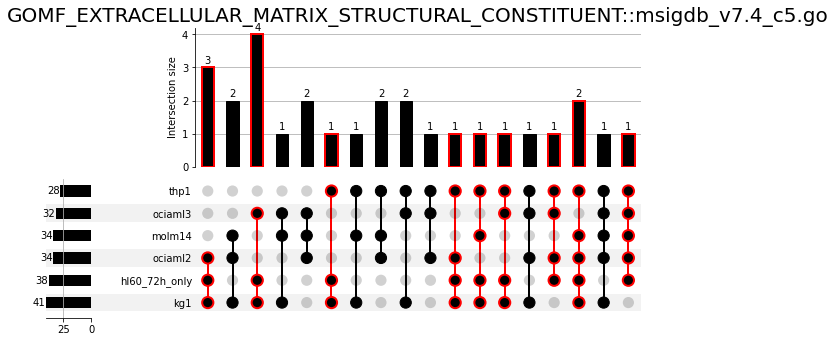

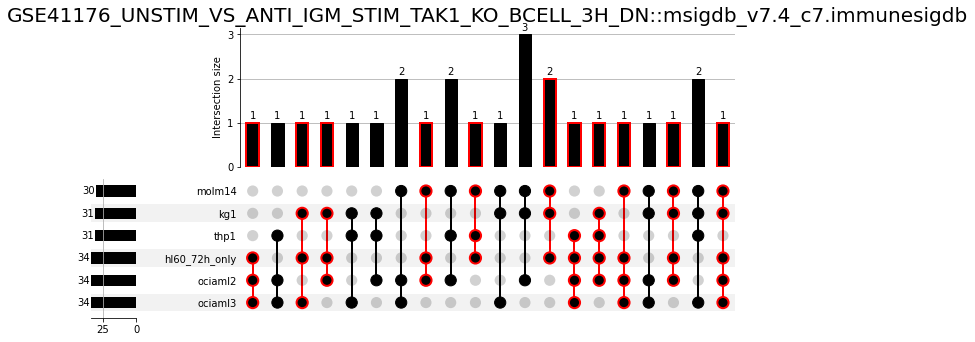

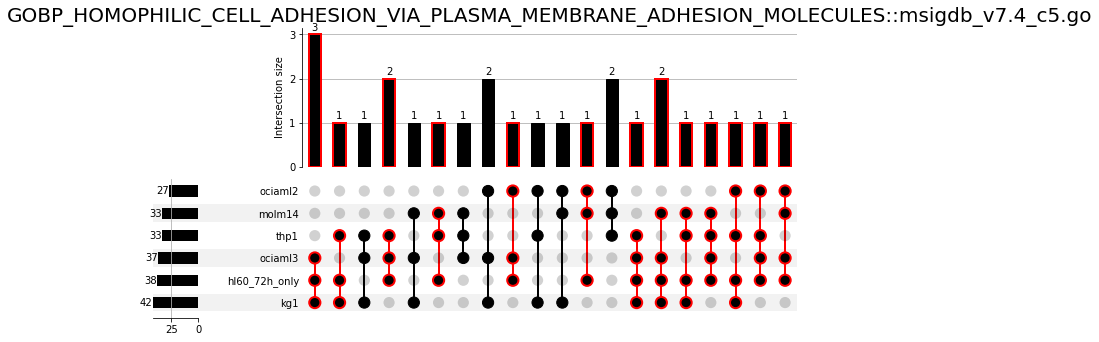

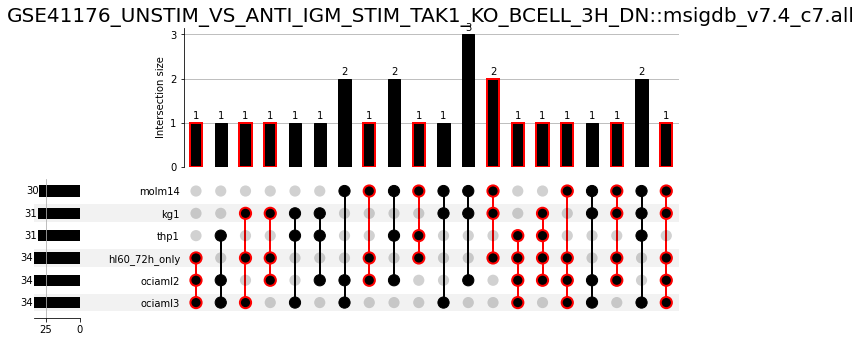

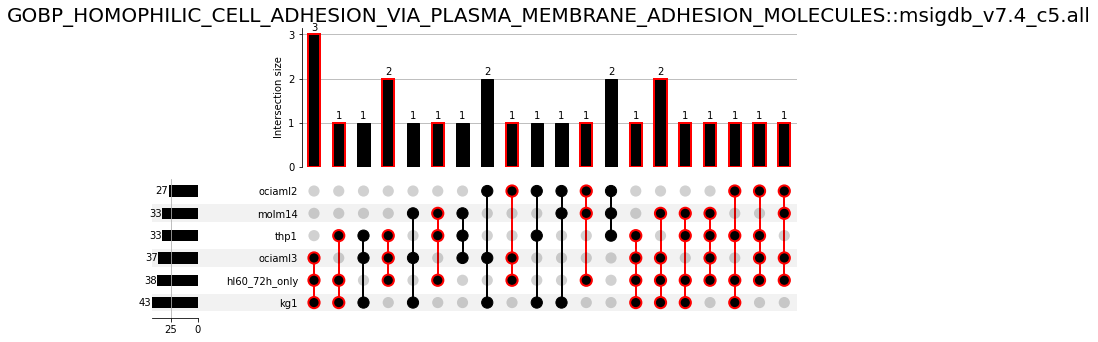

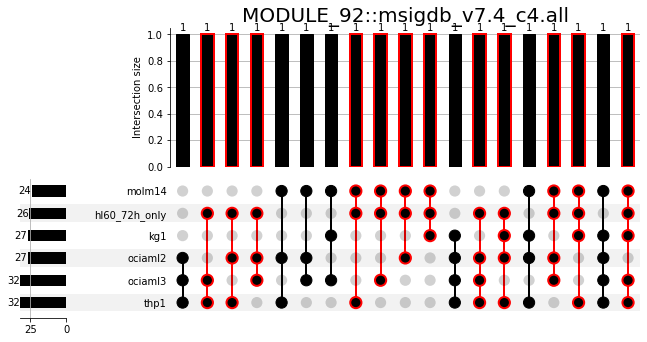

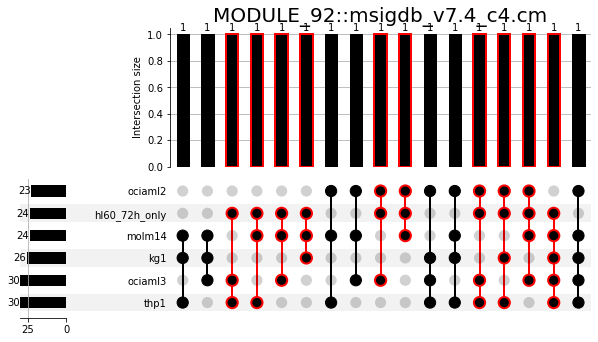

In [459]:
for pw in right_genes:
    fig = plt.figure()
    upset = us.UpSet(
        us.from_contents(right_genes[pw]),
        min_degree=3,
        orientation='horizontal',show_counts=True
    )
    upset.style_subsets(present='hl60_72h_only',edgecolor="red",linewidth=2)
    upset.plot(fig=fig)
    plt.title(pw,fontsize=20)
    plt.show()
    # pdf.savefig()

___
# 

In [19]:
!date

Mon Dec 20 19:19:30 PST 2021
